In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/political-social-media-posts/political_social_media.csv


In [2]:
#read in the data and give labels 1 or 0 for partisan or neutral
data = pd.read_csv('/kaggle/input/political-social-media-posts/political_social_media.csv', usecols=[7,20], names=['bias','text'], encoding='ISO-8859-1')
data.loc[data['bias'] == 'neutral', 'bias'] = 1
data.loc[data['bias'] == 'partisan', 'bias'] = 0
data.head()

,bias,text
0,bias,text
1,0,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...
2,0,VIDEO - #Obamacare: Full of Higher Costs and ...
3,1,Please join me today in remembering our fallen...
4,1,RT @SenatorLeahy: 1st step toward Senate debat...


In [3]:
import re
#preprocess the twitter data and remove all unecessary characters
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    return text

# Apply the preprocessing function to the 'text' column
data['cleaned_text'] = data['text'].apply(preprocess_text)

#turn the cleaned text into an array
text = data['cleaned_text'].to_numpy()
X = text[1:]

#do the same for the y values (I had to use .values to get it to work for some reason)
y = data['bias'].values
y = y[1:]
print(X)
print(y)

['rt  rep trey radel r  slams   '
 'video    full of higher costs and broken promises '
 'please join me today in remembering our fallen heroes and honoring the men and women currently in military service for their sacrifices'
 ...
 'taken from posted wokv interview   congressman yoho says the decision to release the detainees in exchange for a soldier the us military says walked away from his post in afghanistan was poor leadership he also believes it sets a bad precedent  our enemies dont fear or respect us and i think respect is the most important part here   '
 'join me next week for a town hall in ocala ill be there to answer any questions you might have '
 'foreign affairs committee hearing on syria i remain opposed to military intervention but am always willing to hear different points of view this hearing sheds some light on the refugee situation check it out here']
[0 0 1 ... 1 1 1]


In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Split the dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create the vectorizer
cv = CountVectorizer()

# Fit the vectorizer on the training data
X_train_cv = cv.fit_transform(X_train)

# Transform the validation and test data using the vectorizer
X_val_cv = cv.transform(X_val)
X_test_cv = cv.transform(X_test)

y_train = np.array(y_train, dtype=int)
y_test = np.array(y_test, dtype=int)


In [5]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Instantiate the SVM classifier
svm_classifier = SVC()

# Train the classifier
svm_classifier.fit(X_train_cv, y_train)

# Make predictions on the test set
y_test_pred_svm = svm_classifier.predict(X_test_cv)

# Calculate and report the accuracy
svm_accuracy = accuracy_score(y_test, y_test_pred_svm)
print(f"SVM accuracy: {svm_accuracy:.4f}")


SVM accuracy: 0.7640


In [6]:
from sklearn.naive_bayes import MultinomialNB

# Instantiate the Naive Bayes classifier
nb_classifier = MultinomialNB()

# Train the classifier
nb_classifier.fit(X_train_cv, y_train)

# Make predictions on the test set
y_test_pred_nb = nb_classifier.predict(X_test_cv)

# Calculate and report the accuracy
nb_accuracy = accuracy_score(y_test, y_test_pred_nb)
print(f"Naive Bayes accuracy: {nb_accuracy:.4f}")


Naive Bayes accuracy: 0.7520


In [7]:
#I just did this to take a look at some extra metrics, it looks like SVM is the best

from sklearn.metrics import precision_score, recall_score, f1_score

def print_metrics(y_true, y_pred, classifier_name):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"{classifier_name} Precision: {precision:.4f}")
    print(f"{classifier_name} Recall: {recall:.4f}")
    print(f"{classifier_name} F1-score: {f1:.4f}")
    print()

# SVM Metrics
print_metrics(y_test, y_test_pred_svm, "SVM")

# Naive Bayes Metrics
print_metrics(y_test, y_test_pred_nb, "Naive Bayes")

SVM Precision: 0.7695
SVM Recall: 0.9842
SVM F1-score: 0.8637

Naive Bayes Precision: 0.8616
Naive Bayes Recall: 0.8026
Naive Bayes F1-score: 0.8311



**SVM (Support Vector Machine) - sklearn.svm.SVC**
Hyperparameters:
C: Regularization parameter, default=1.0
kernel: Kernel type, default='rbf'
gamma: Kernel coefficient, default='scale'

**Naive Bayes - sklearn.naive_bayes.MultinomialNB**
Hyperparameters:
alpha: Additive (Laplace/Lidstone) smoothing parameter, default=1.0
fit_prior: Whether to learn class prior probabilities, default=True
class_prior: Prior probabilities of the classes, default=None

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the hyperparameter grid
param_grid = {'C': [0.1, 1, 10],
              'kernel': ['linear', 'rbf'],
              'gamma': ['scale', 'auto']}

# Initialize the classifier
svm = SVC()

# Create a GridSearchCV object
grid_search = GridSearchCV(svm, param_grid, scoring='accuracy', cv=5, verbose=1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_cv, y_train)

# Get the best combination of hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Get the prediction accuracy on the validation set
best_val_accuracy = grid_search.best_score_
print("Best validation accuracy:", best_val_accuracy)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best hyperparameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best validation accuracy: 0.745


In [9]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters and their ranges
hyperparameters_nb = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'fit_prior': [True, False]
}

# Instantiate a Multinomial Naive Bayes classifier
nb = MultinomialNB()

# Create a GridSearchCV object and fit it to the training data
nb_grid = GridSearchCV(nb, hyperparameters_nb, cv=5, scoring='accuracy')
nb_grid.fit(X_train_cv, y_train)

# Print the best hyperparameters
print("Best hyperparameters for Naive Bayes:", nb_grid.best_params_)

# Print the accuracy score on the test set with the best hyperparameters
nb_best = nb_grid.best_estimator_
nb_best_pred = nb_best.predict(X_test_cv)
nb_best_acc = accuracy_score(y_test, nb_best_pred)
print(f"Accuracy on the test set with best hyperparameters for Naive Bayes: {nb_best_acc:.4f}")


Best hyperparameters for Naive Bayes: {'alpha': 1, 'fit_prior': True}
Accuracy on the test set with best hyperparameters for Naive Bayes: 0.7520


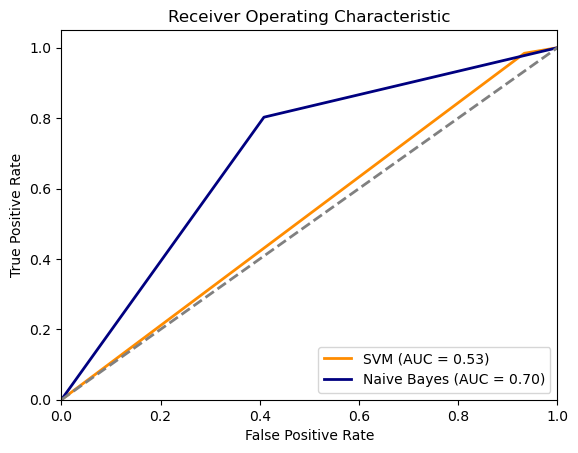

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve and AUC for SVM
svm_fpr, svm_tpr, _ = roc_curve(y_test, y_test_pred_svm)
svm_auc = auc(svm_fpr, svm_tpr)

# Calculate ROC curve and AUC for Naive Bayes
nb_fpr, nb_tpr, _ = roc_curve(y_test, y_test_pred_nb)
nb_auc = auc(nb_fpr, nb_tpr)

# Plot ROC curves
plt.plot(svm_fpr, svm_tpr, color='darkorange', lw=2, label='SVM (AUC = %0.2f)' % svm_auc)
plt.plot(nb_fpr, nb_tpr, color='navy', lw=2, label='Naive Bayes (AUC = %0.2f)' % nb_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
